In [7]:
from radishlib import *
# import cv2
# import matplotlib
%matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt

from ipywidgets import *
from thin.thin import getSkelline
# from __future__ import print_function
# 処理対象画像
imgfile = 'pics/daikonkabu.jpg'
# 表示のオンオフ
IMGON = True

In [8]:
# カラー画像の読み込み
src = cv2.imread(imgfile) 
# 同じ画像をグレー画像として読み込み
gry = cv2.imread(imgfile,0)
plotimg(src)

左上からしきい値
              60     80    100   120
            140  160  180  200


<IPython.core.display.Javascript object>


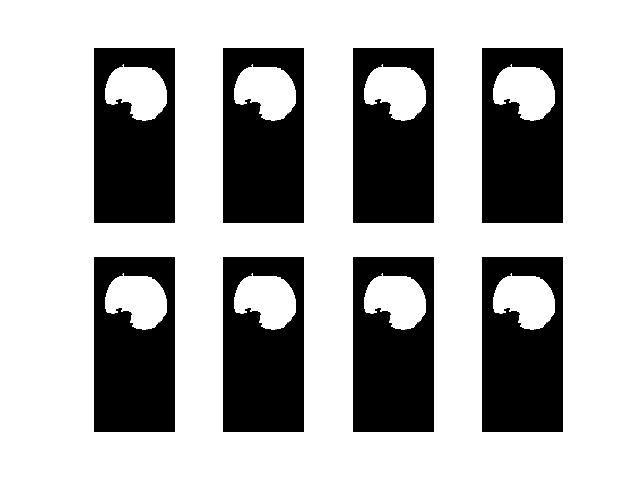

In [11]:
#　２階調化 パラメータは白と黒のしきい値  default= 70
# open = True  白のゴミ取りを２回実行
# close = True 黒孔、溝を埋める処理を２回実行

print(u"左上からしきい値\n              60     80    100   120\n            140  160  180  200")
for i in range(8):
    plotimg(dthreshold(bw,40+20*i,True,True),"24"+str(i+1))
 

適切なしきい値がどれくらいであるかを見積もる

In [5]:
# OTSU の方法による適切なしきい値
ret,thresh2 = cv2.threshold(gry,0,255,cv2.THRESH_OTSU)
print("OTSUの方法によるおすすめ値は {}".format(ret))

OTSUの方法によるおすすめ値は 120.0


<IPython.core.display.Javascript object>


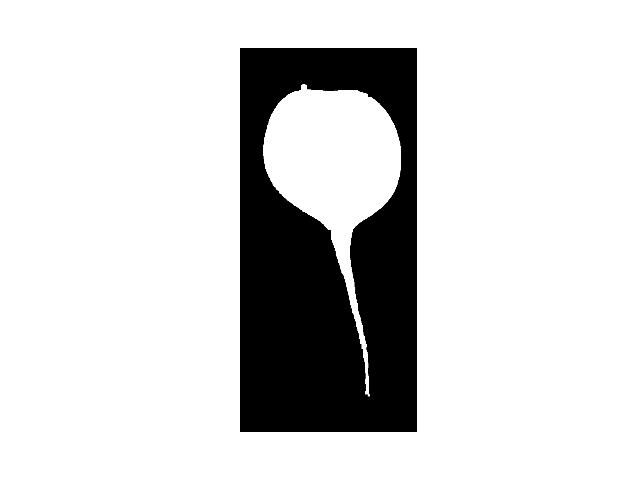

In [6]:
#　２階調化 パラメータは白と黒のしきい値  default= 大津の方法より低めの方がよさげ
# open = True  白のゴミ取りを２回実行
# close = True 黒孔、溝を埋める処理を２回実行
@interact(thres=(0,255,1), open=True, close=True)
def dth(thres=ret*.6, open=True, close=True):
    global gry, bw
    dthreshold(thres, open, close)
    plotimg(bw)

In [8]:
# 黒連結成分のラベリング 
output = cv2.connectedComponentsWithStats(~bw, connectivity = 8)
# Get the results
num_labels = output[0]  # 連結成分の数
labels = output[1] # ラベル画像
stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
menseki = stats[:,cv2.CC_STAT_AREA]
centroids = output[3]
print(num_labels,labels.shape,menseki,centroids.shape)

2 (1334, 609) [198157 614249] (2, 2)


<IPython.core.display.Javascript object>


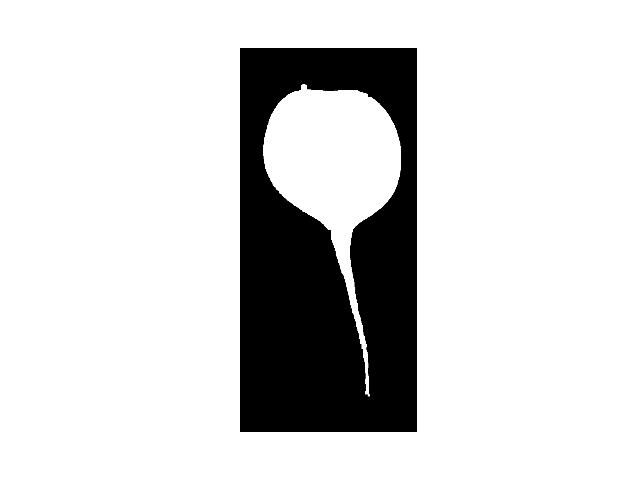

In [9]:
# 小領域の削除
img= np.zeros(gry.shape,dtype=np.uint8)
for i in range(1,num_labels ):
        if  stats[i][cv2.CC_STAT_AREA] > gry.shape[0]+gry.shape[1]:
            img = img + np.uint8(labels==i)*255
edge = img        
plotimg(~edge)

どの程度の面積をノイズとすべきかは、一般的には難しい問題である。
上のプログラムでは、画像の縦と横の長さの和よりも小さい領域は無視するようにしている。

In [10]:
# 結果確認のために色付けしてみる
import random,copy

def showlabelimage(labels, num_labels):
    dst = copy.copy(src)
    colors = []
    for i in range(1, num_labels+1):
        colors.append(np.array([random.randint(100, 255), random.randint(0, 255), random.randint(0, 255)]))

    for y in range(0, labels.shape[0]):
        for x in range(0, labels.shape[1]):
            if labels[y, x] > 0:
                dst[y, x] = colors[labels[y, x]]
            else:
                dst[y, x] = [0, 0, 0]
    return dst

dst = showlabelimage(labels,num_labels)

In [11]:
# 白連結成分のラベリング 
output = cv2.connectedComponentsWithStats(~edge, connectivity = 4)  # 白領域の場合は４連結処理であることに注意
# Get the results
num_labels = output[0]  # 連結成分の数
labels = output[1] # ラベル画像
stats = output[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
menseki = stats[:,cv2.CC_STAT_AREA]
centroids = output[3]
print(num_labels,labels.shape,menseki,centroids.shape)

2 (1334, 609) [614249 198157] (2, 2)


<IPython.core.display.Javascript object>


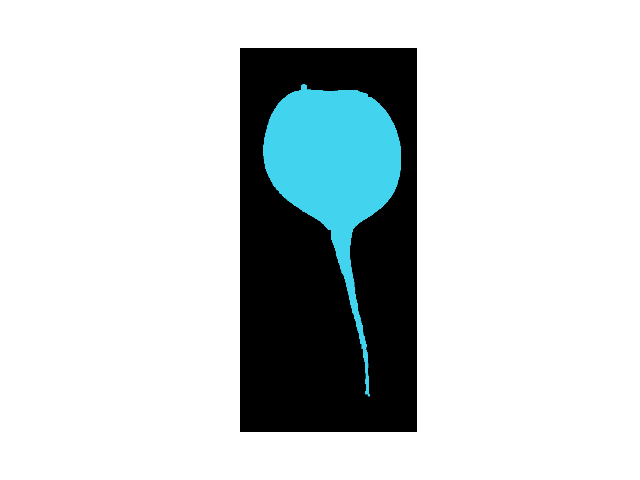

In [12]:
dst = showlabelimage(labels,num_labels)
plotimg(dst)

In [13]:
# 1番大きな領域がダイコンの主要部分であると仮定する。
sortedindex = menseki[1:].argsort()[::-1]  # ０番以外をソーティングしたときの値の多い順に index を並べたもの
dnum = sortedindex[0] # 1番多いデータのインデックス。
print(sortedindex,menseki,dnum)

daikonimg = np.uint8(labels==dnum+1)*255

[0] [614249 198157] 0


<IPython.core.display.Javascript object>


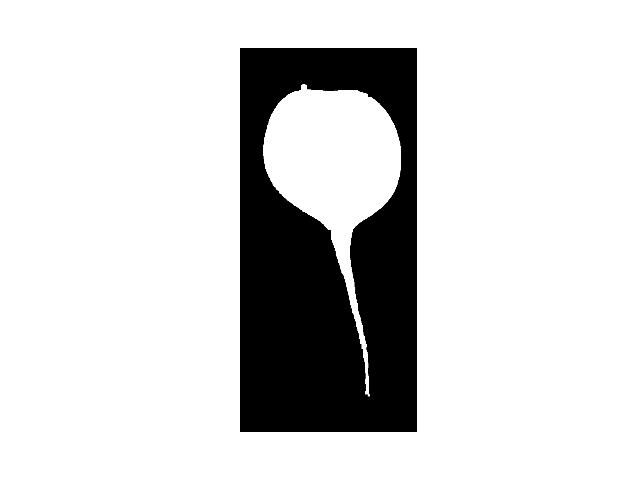

In [14]:
plotimg(daikonimg)

argsort 関数は、値の昇順に並べ替えたときの、値ではなくインデックスを並べ替えたリストを返す関数。
「１：] は1番目以降のデータという意味。番号は0番から始まる。0番目は黒画素の総数なので、1番目以降を並べ替える。
[::-1]は逆順に並べ替えることを意味する。逆順に並べ替えたインデックスの０番は１番大きい領域の番号、１番目は２番目。
欲しいのは２番なので、 sortedindex[1]がダイコンの主要部の領域番号にほかならない。

領域の番号は０から始まるが、ラベリング時のラベル番号は１から始まるので、labelsという配列のうち、
ｄnuｍ＋１ に一致する(labels==dnum+1)画素を２５５（白）とする。

In [15]:
# 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
dist = cv2.distanceTransform(daikonimg,cv2.DIST_L2,5)

距離変換関数の第２引数は距離の測り方。
DIST_L１ 4近傍距離。上下左右は１，　ななめは距離２と数える。
DIST_L2　ユークリッド距離
DIST_C　８近傍距離。上下もななめも距離１と数える。

In [16]:
# 最大の距離は？　　　これが最大半径となる
maxR = np.max(dist)
maxR

222.29613

<IPython.core.display.Javascript object>


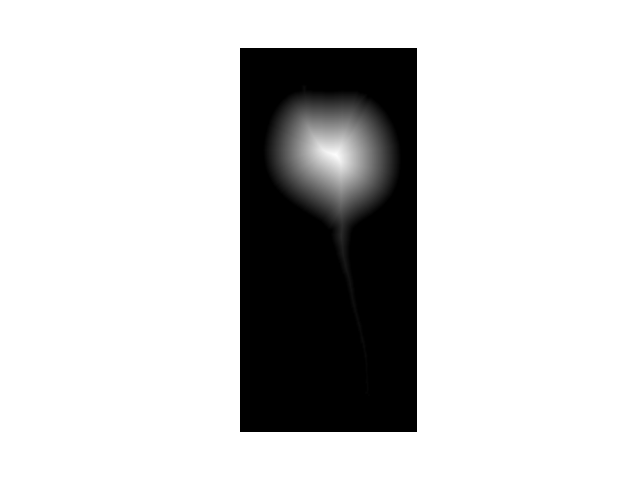

In [17]:
# 最大値が白（最大輝度）になるようダイナミックレンジの拡大をしてみる
distimg = ((dist/maxR)*255).astype('uint8')
plotimg(distimg)

スケルトン画像


<IPython.core.display.Javascript object>


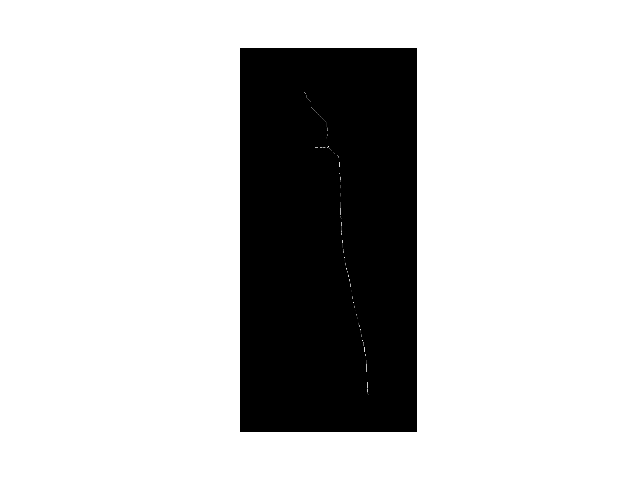

In [18]:
# スケルトン画像の生成
# skelimg = skelton(dist)
skelimg = getSkelline(daikonimg)
print(u'スケルトン画像')
plotimg(skelimg)    

In [20]:
# 指定されたピクセルの周囲のピクセルを取得
def neighbours(x, y, image):
    ns = [image[y][x+1],image[y-1][x+1],image[y-1][x], image[y-1][x-1],image[y][x-1],  # X１, X２, X３, X４, X5
    image[y+1][x-1],image[y+1][x], image[y+1][x+1],image[y][x+1], image[y-1][x+1] ]    # X6, X7, X8,X1,X2 
    for i in range(10): ns[i] = ns[i]/255
    return ns

# 連結数 (8連結)
def connection_number(neighbours):
    n = 1-np.array(neighbours)
    return sum((1-n)[:-2]), sum( n[i] -  n[i]*n[i+1]*n[i+2]  for  i in range(0,7,2)) 

# スケルトンのリストを生成する関数、細線化バージョン
def skellist(skel, dist):
    # skel 細線化済み画像データ
    # dist 距離画像データ
    # bwの白(255)連結成分を細線化し、残った画素の座標と距離データからなるタプルのリストを返す
    (height,width) = skel.shape
    result = []
    for i in range(1,height-1):
        for j in range(1,width-1):
            if skel[i][j]>0:
                numberof1, cn = connection_number(neighbours(j,i,skel))
                # この時点でまだ消去可能な画素が残っていれば削除する
                if  skel[i][j] == 255 and  cn==1 and numberof1 > 1  : 
                    skel[i][j] = 0
                else:
                    result.append([i,j,dist[i][j]])
    return result


1117


<IPython.core.display.Javascript object>


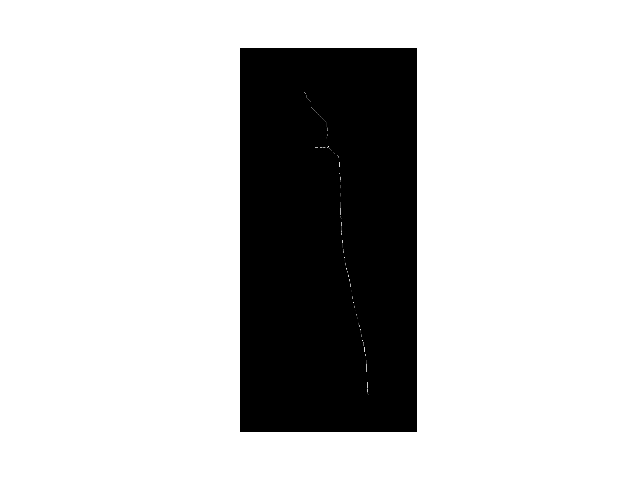

In [21]:
# スケルトンデータを生成
skeldata = skellist(skelimg,dist)
print(len(skeldata))
plotimg(skelimg)  

In [22]:
# スケルトンデータから2値画像データを復元 （検証のため）
def skel2img(skeldata,shape,skelimg):
    img = np.zeros(shape,dtype=np.uint8)
    zeroimg = np.zeros(skelimg.shape,dtype=np.uint8)
    mask = cv2.merge((skelimg,skelimg,zeroimg))
    plotimg(mask)
    for i in range (len(skeldata)):
        cv2.circle(img,(skeldata[i][1],skeldata[i][0]),int(skeldata[i][2]),(255,255,255),-1)
    # plt.imshow(mask)
    return cv2.bitwise_xor(img,mask)

<IPython.core.display.Javascript object>


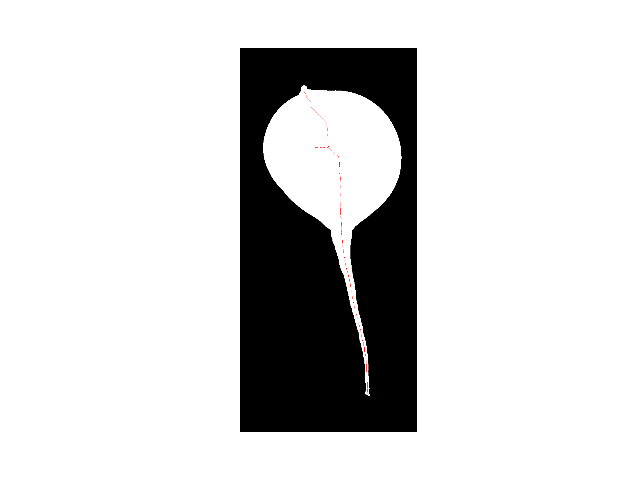

In [23]:
recallimg = skel2img(skeldata,src.shape,skelimg)
plotimg(recallimg)


スケルトンデータから元の画像が復元可能であることが確認できた。
矩形に近い形の細線化結果やスケルトンは末端に近い部分が二股に別れる。
この例では上の部分がそうである。二股に別れる

segment 数 2
分岐点( 304 347 )　連結数＝ 3.0
segments number =  4 [811290    205     48    863]
2
segment 数 2
segments number =  2 [811337   1069]


<IPython.core.display.Javascript object>


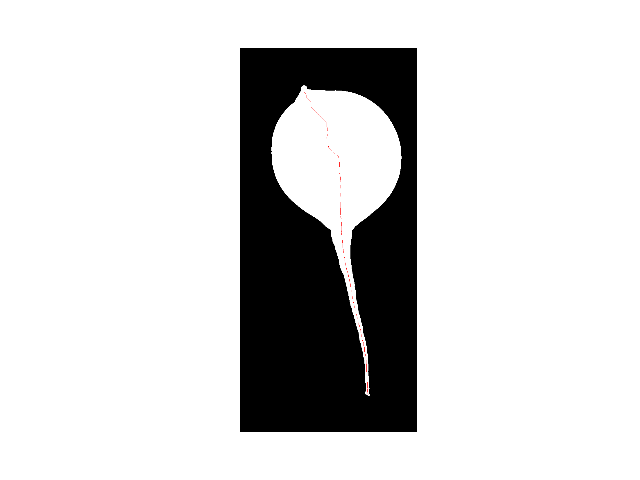

In [24]:

# スケルトンを分岐点で分割してセグメントをラベリング
def skllabel(skelimg,  skeldata):
    con = True
    tmpimg = np.array(skelimg,dtype=np.uint8)
    while con:
        con = False
        for skelton in skeldata:
            x = skelton[1]
            y = skelton[0]
            numberof1, cn = connection_number(neighbours(x,y,tmpimg))
            if  tmpimg[y][x] == 255 and  (cn > 2 or cn==1 and numberof1 > 1 ) : 
                con = True
                tmpimg[y][x] = 0
                print("分岐点(",x,y,')　連結数＝', cn)
    out = cv2.connectedComponentsWithStats(tmpimg, connectivity = 8) 
    return out

con = True
tmplabelimg =  np.array(skelimg,dtype=np.uint8)
ｔｍｐimg = np.array(skelimg,dtype=np.uint8)

tmpout = cv2.connectedComponentsWithStats(tmplabelimg, connectivity = 8)       
# 処理前のセグメント数を調べる
print("segment 数",tmpout[0])

while con:
    # 分岐点があればそこで分割する
    skelout = skllabel(tmplabelimg,skeldata)
    num_segments = skelout[0]  # セグメント数
    segmentimg = skelout[1] # ラベル画像
    segmentspecs= skelout[2] # 属性情報の配列　cv2.CC_STAT_AREA番が面積me
    seglength = segmentspecs[:,cv2.CC_STAT_AREA]     
    print("segments number = ",num_segments, seglength)
    if num_segments == 2:
        con = False
    else:
        # 一番短いセグメントのラベル番号を調べそのセグメントを削除してみる
        shortsegmentlabel = np.argmin(seglength)
        print(shortsegmentlabel)
        for y in range(0, tmpimg.shape[0]):
            for x in range(0, tmpimg.shape[1]):
                if segmentimg[y][ x] == shortsegmentlabel:
                    tmplabelimg[y][ x] = 0
        tmpout = cv2.connectedComponentsWithStats(tmplabelimg, connectivity = 8)       
        # ヒゲを削除したのであれば、ラベルつけをしてもラベルの数は背景を加えて２つであるはず
        print("segment 数",tmpout[0])
        if tmpout[0] > 2:
            tmplabelimg = np.array(tmpimg,dtype=np.uint8)
            # ラベルが３つ以上なら画像を元にもどす
        else:
            # ヒゲであった場合は画像を更新する
            tmpimg = np.array(tmplabelimg,dtype=np.uint8)
        seglength = seglength[:shortsegmentlabel]+seglength[shortsegmentlabel+1:]
        # さきほど削除してみたラベル番号は対象からはずす

plotimg(tmplabelimg)

In [25]:
# スケルトンデータを再生成
skelimg=tmplabelimg
skeldata = skellist(skelimg,dist)
print(len(skeldata))
recallimg = skel2img(skeldata,src.shape,skelimg)
plotimg(recallimg)

1069


ヒゲの分だけ形状は変化してしまうが、棒状からはずれるものは仕方ない

In [30]:
# skeltondata を numpy array へ変換
skd = np.array(skeldata)

In [31]:
# 黒画素から最も距離のある，内部の点を基準点として選ぶ
normP = np.argmax(skd[:,2])
xnorm = skd[normP][1]
ynorm = skd[normP][0]
print (xnorm,ynorm)

330.0 372.0


In [32]:
# 基準点からの距離の配列を生成
distance = np.array([np.sign(x-xnorm)*np.sqrt((x-xnorm)**2 + (y - ynorm)**2)  for (y,x) in skd[:,0:2]] ) 

In [33]:
#基準点からの距離でインデックスを並べ替え
index = np.argsort(distance) # 距離順にインデックスを並べ替え
skd = skd[index] # スケルトンデータを距離順に並べ替え
distance = distance[index] # 距離データも並べ替え
skdp = np.array([ list(np.append(s,d)) for (s,d) in zip(skd,distance)])
# skpd はスケルトンの(y座標,x座標,輪郭までの距離,基準点からの距離)のリスト

#  並べ替えたので基準点のインデックスを再度調べ直す
normP = np.argmax(skd[:,2])
print (u'基準点',normP,'(',xnorm,ynorm,')')

基準点 233 ( 330.0 372.0 )


In [34]:
# スケルトンの位置データ補正
def recalcDistanceP(skdata,normP):
    skdpbackup=np.array(skdata)
    # 曲線に沿った距離を求める。理屈では積分していけばいいが
    # デジタル画像では近い画素間の距離は誤差が大きいので10点ごとに
    # 基準点を設け、基準点間の距離の積算＋最寄りの基準点からの距離を
    # 曲線に沿った距離の近似に使う
    xnorm = skdata[normP][1]
    ynorm = skdata[normP][0]
    cnt = 0 # ベースからの画素数 
    accdistAtBase = 0 # 基準点から現在のベースまでの距離の積算
    predist = skdpbackup[0][3]  # 先端のデータ（最も誤差が大きいはず）
    for sk in skdata[normP-1::-1]:
            y = sk[0]
            x = sk[1]
            sk[3] = accdistAtBase - np.sqrt((x-xnorm)**2 + (y - ynorm)**2) 
            cnt = cnt+1
            if cnt==10 :
                accdistAtBase = sk[3]
                (ynorm,xnorm) = (y,x)
                cnt = 0
    print(u"左側修正量 {} ({} -> {})".format(predist-skdata[0][3],predist,skdata[0][3]))
    xnorm = skdata[normP][1]
    ynorm = skdata[normP][0]
    cnt = 0 # ベースからの画素数 
    accdistAtBase = 0 # 基準点から現在のベースまでの距離の積算
    predist = skdpbackup[-1][3]  # 葉元のデータ（こちらも誤差が大きいはず）
    for sk in skdata[normP+1::]:
            y = sk[0]
            x = sk[1]
            sk[3] = accdistAtBase + np.sqrt((x-xnorm)**2 + (y - ynorm)**2) 
            cnt = cnt+1
            if cnt==10 :
                accdistAtBase = sk[3]
                (ynorm,xnorm) = (y,x)
                cnt = 0
    print(u"右側修正量 {} ({} -> {})".format(skdata[-1][3]-predist,predist,skdata[-1][3]))

（解説）径の一番太い位置の中心を基準点 normP として選び、その点からの距離でスケルトン画素を並べ換える。
もしスケルトンが直線状に並んでいるのならば求めた距離は中心軸に沿った距離に等しいが、湾曲している場合、
基準点からの直線距離と軸に沿って測った距離は基準から離れるほどズレが生じてくる。

形状を評価する場合、湾曲を補正した形状を求める必要があるが、それには直線距離ではなく、
軸に沿って測った距離を使うほうが適切である。

理屈の上では軸に沿って距離を積分、つまり積算していけばよいが、デジタル画像の場合近い点の距離は誤差が大きい。
例えば斜め45度に並ぶ点列の距離は1点ずつ距離を積算してしまうと実際の距離のルート２倍になってしまう。

そこで、曲がりが少ないであろう、１０点ごとに距離を測る基準点を設定し、
（基準点間距離＋最寄りの基準点からの距離）で、軸に沿った距離を近似する。

In [35]:
recalcDistanceP(skdp,normP)

左側修正量 16.804708389281274 (-254.95097567963924 -> -271.7556840689205)
右側修正量 8.97866718494754 (787.1696132346573 -> 796.1482804196048)


<IPython.core.display.Javascript object>


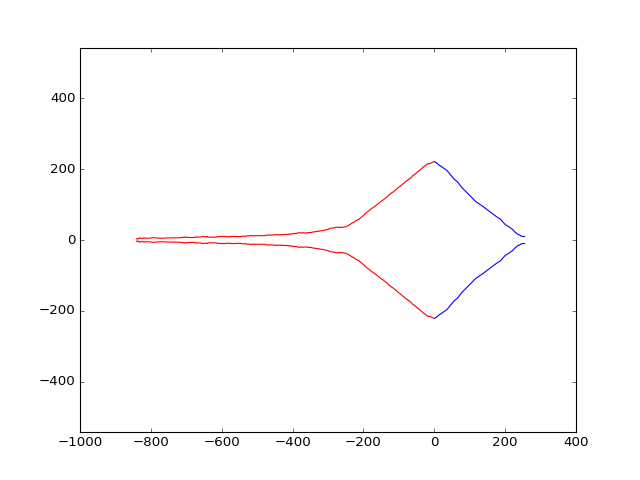

In [49]:
@interact(invert=False)
def radiusfunc(invert=True):
    if invert:
        for d in skdp: d[3]=-d[3]
    skdN = skdp[skdp[:,3]<= 0] # 基準点より左のデータ
    skdP = skdp[skdp[:,3] > 0] # 基準点より右のデータ
    
    # 横軸を基点からのスケルトン位置までの距離，縦軸をそのスケルトンの距離データとしたグラフ                          
    plt.axis('equal')    
    plt.hold(True)
    ydata = np.array(skdN[:,2])
    xdata = np.array(skdN[:,3])
    plt.plot(xdata,ydata,'-',color=(1,0,0.0))
    plt.plot(xdata,-ydata,'-',color=(1,0,0.0))
    ydata = np.array(skdP[:,2])
    xdata = np.array(skdP[:,3])
    plt.plot(xdata,ydata,'-',color=(0,0,1.0))
    plt.plot(xdata,-ydata,'-',color=(0,0,1.0))
    plt.hold(False)
    plt.show()
    
    # invert で再描画する際には、グラフの描画を一旦停止すること。
    # 停止しないと描画されないので注意。

In [54]:
# スケルトンを直線状に再配置し、曲がりを補正した画像を生成する
def makeNormalizedImage(skdp):
    print("中心軸の画素数={}".format(len(skdp)))
    maxh = np.max(skdp[:,2]) # もっとも近い輪郭までの距離
    maxw = np.max(skdp[:,3]) # 基準点からの距離の最大値
    minw = np.min(skdp[:,3]) # 基準点からの距離の最小値
    nimg = np.zeros((int(3*maxh),int(1.5*(maxw-minw)),3),dtype=np.uint8) # 50%マージンで描画用エリアを確保
    cent = np.array((int(1.5*(-minw)),int(1.5*maxh))) # 基準点の画像内座標
    for i in range(len(skdp)):
        center = (int(skdp[i][3])+cent[0],cent[1])
        radius = int(skdp[i][2])
        color = (255,255,255) # White
        thickness = -1 # 塗りつぶし
        nimg = cv2.circle(nimg,center,radius,color,thickness)
    mask = nimg[:,cent[0]:,:]
    cv2.threshold(mask,127,128,cv2.THRESH_BINARY,dst=mask)
    nimg = cv2.cvtColor(nimg,cv2.COLOR_BGR2GRAY)
    return nimg


中心軸の画素数=1069


<IPython.core.display.Javascript object>


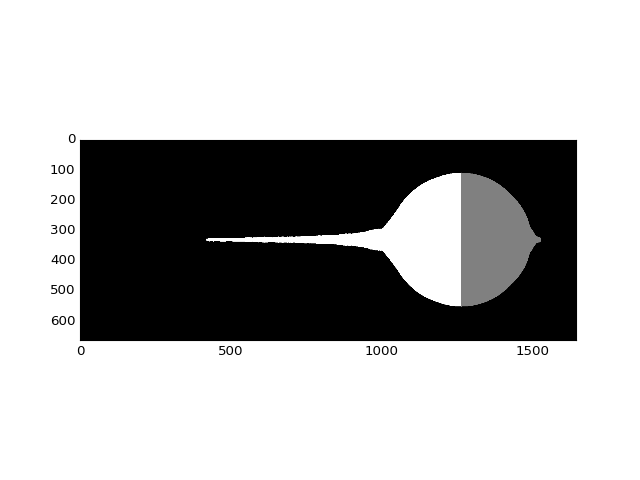

In [55]:
# 中心線を直線化して形状整形した画像の生成
norzimg = makeNormalizedImage(skdp)
plotimg(norzimg)

In [56]:
# 輪郭線の抽出
# mode 0  全体の輪郭　　mode 1 最大径より先だけの輪郭  mode 2 先の上半分だけ
def  getContour(img, mode):
    center = img.shape[0]/2
    if mode == 0:
        ret, bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY)        
    else:
        ret, bw = cv2.threshold(img,200,255,cv2.THRESH_BINARY)  
    image, contours, hierarchy = cv2.findContours(bw,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    if  mode ==2:
        cnt = []
        maxx = np.max(contours[:][0][1])
        for i in contours[0]:
            if i[0][1] >= center and i[0][0]<maxx :
                cnt.append([list(i[0])])
            contours = np.array([cnt])
    return image,contours

<IPython.core.display.Javascript object>


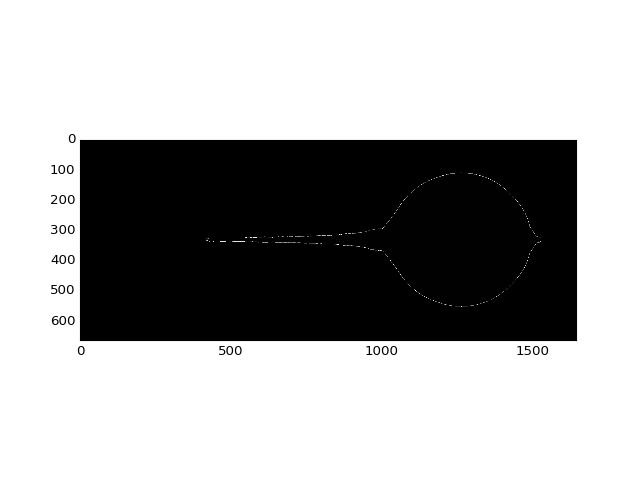

In [57]:
bw,cnt = getContour(norzimg,0)
cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
plotimg(bw)

<IPython.core.display.Javascript object>


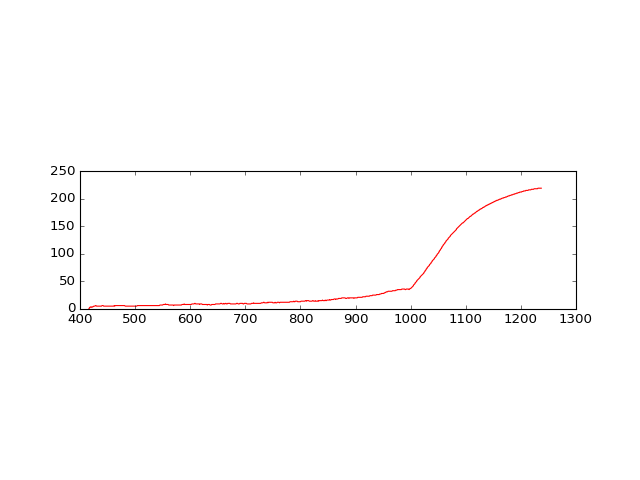

In [58]:
# 先端部分だけの点列の生成
bw,cnt = getContour(norzimg,2)
xdata = [i[0][0]  for i in cnt[0]]
ydata = [i[0][1]- bw.shape[0]/2 for i in cnt[0]] 
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdata,ydata,"r")

<IPython.core.display.Javascript object>


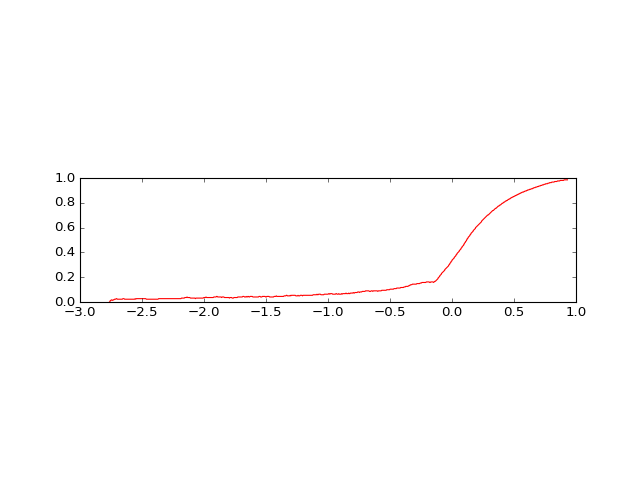

In [59]:
def shiftX(dx,dy,shift):
         found = False
         offset = 0.0
         for (x,y) in zip(dx,dy):
            if not found and y >shift:
                found = True
                offset = x
         dx = dx - offset
         return dx,dy

# 最大径を基準に正規化
xdataR = np.array(xdata)/maxR 
ydataR= np.array(ydata)/maxR
xdataR,ydataR = shiftX(xdataR,ydataR,1/3)    # y = 1/3 付近が x=0 になるようにデータ全体をｘ軸に沿ってシフト
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdataR,ydataR,"r")

In [60]:
from fit1 import fit1

$y = \frac{1}{1+e^{-a(x-b)}}=\frac{1}{1+Be^{-ax}}$ にフィッティング

    0:(a,b,err) = (    0.0727,    0.0000,     0.0917)
  200:(a,b,err) = (    3.0510,    0.0845,     0.0053)
  400:(a,b,err) = (    3.8870,    0.1140,     0.0016)
  600:(a,b,err) = (    4.3020,    0.1217,     0.0007)
  800:(a,b,err) = (    4.5447,    0.1249,     0.0004)
 1000:(a,b,err) = (    4.6978,    0.1265,     0.0003)
 1200:(a,b,err) = (    4.7987,    0.1274,     0.0002)
 1400:(a,b,err) = (    4.8669,    0.1280,     0.0002)
 1600:(a,b,err) = (    4.9138,    0.1284,     0.0002)
 1800:(a,b,err) = (    4.9464,    0.1286,     0.0002)
 2000:(a,b,err) = (    4.9692,    0.1288,     0.0002)


<IPython.core.display.Javascript object>


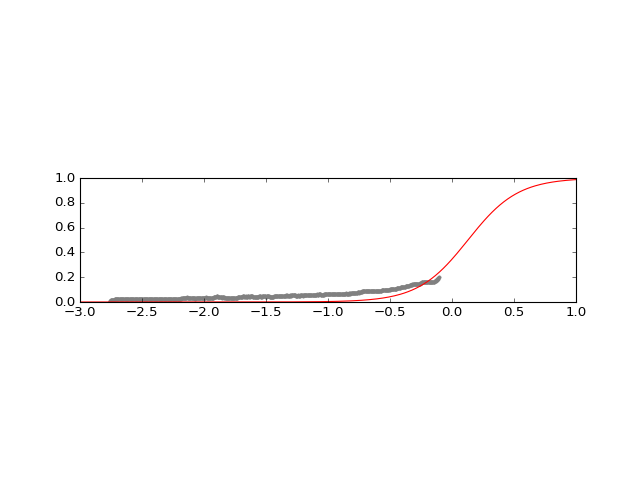

In [61]:
fit1((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=1,cutoff=0.2)

In [48]:
from fit2  import fit2

$$y = \frac{1}{1+e^{-a(x-c)}(1+e^{-b(x-c)})}$$にフィッティング

    0:(a,b,c,err) = (    2.0157,    6.0008,    -0.0771,     0.0066)
  200:(a,b,c,err) = (    3.0003,    6.0157,    -0.0161,     0.0007)
  400:(a,b,c,err) = (    3.2978,    6.0177,    -0.0053,     0.0002)
  600:(a,b,c,err) = (    3.4297,    6.0121,    -0.0011,     0.0001)
  800:(a,b,c,err) = (    3.4953,    6.0027,     0.0008,     0.0001)
 1000:(a,b,c,err) = (    3.5297,    5.9914,     0.0018,     0.0001)
 1200:(a,b,c,err) = (    3.5484,    5.9792,     0.0023,     0.0001)
 1400:(a,b,c,err) = (    3.5589,    5.9664,     0.0025,     0.0001)
 1600:(a,b,c,err) = (    3.5650,    5.9535,     0.0027,     0.0001)
 1800:(a,b,c,err) = (    3.5687,    5.9404,     0.0027,     0.0001)
 2000:(a,b,c,err) = (    3.5711,    5.9274,     0.0028,     0.0001)


<IPython.core.display.Javascript object>


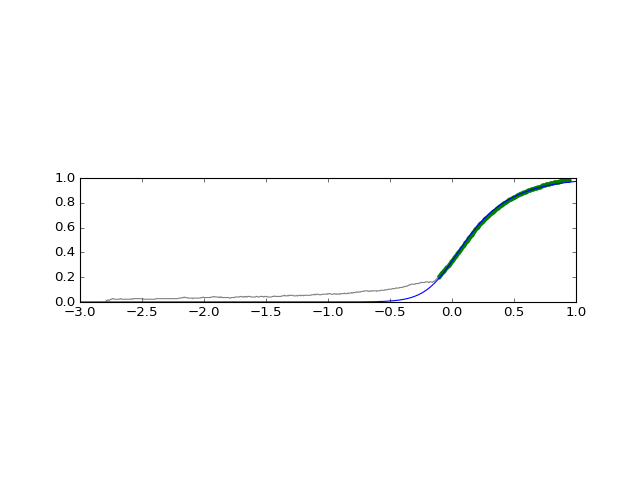

In [49]:
fit2((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=1,cutoff=0.2)

In [50]:
from fit3 import fit3
xdataR,ydataR = shiftX(xdataR,ydataR,0.5)
# fit3 は都合により 半径が0.5 の位置を基準にしてフィッティング

$$y = \frac{1}{1+e^{-a(x-c)(1+e^{-b(x-c)})}}$$
にフィッティング


<class 'tensorflow.python.ops.variables.Variable'>
    0:(a,b,c,err) = (    2.0046,   -0.0011,    -0.0060,     0.0010)
  200:(a,b,c,err) = (    2.3598,   -0.0287,     0.0052,     0.0002)
  400:(a,b,c,err) = (    2.4324,    0.0240,     0.0056,     0.0001)
  600:(a,b,c,err) = (    2.4611,    0.0813,     0.0051,     0.0001)
  800:(a,b,c,err) = (    2.4797,    0.1338,     0.0046,     0.0001)
 1000:(a,b,c,err) = (    2.4947,    0.1804,     0.0041,     0.0001)
 1200:(a,b,c,err) = (    2.5078,    0.2215,     0.0036,     0.0001)
 1400:(a,b,c,err) = (    2.5193,    0.2578,     0.0032,     0.0001)
 1600:(a,b,c,err) = (    2.5294,    0.2899,     0.0029,     0.0001)
 1800:(a,b,c,err) = (    2.5384,    0.3183,     0.0025,     0.0001)
 2000:(a,b,c,err) = (    2.5464,    0.3435,     0.0023,     0.0001)


<IPython.core.display.Javascript object>


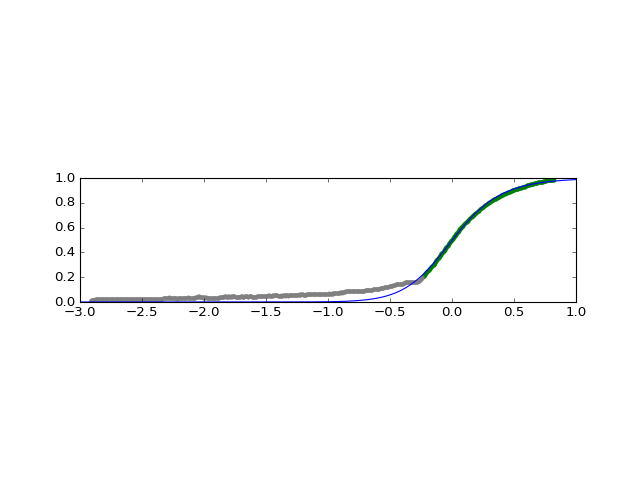

In [51]:
fit３((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=1, cutoff=0.2)

In [24]:
timg = cv2.imread("testimg01.PNG",0)

<IPython.core.display.Javascript object>


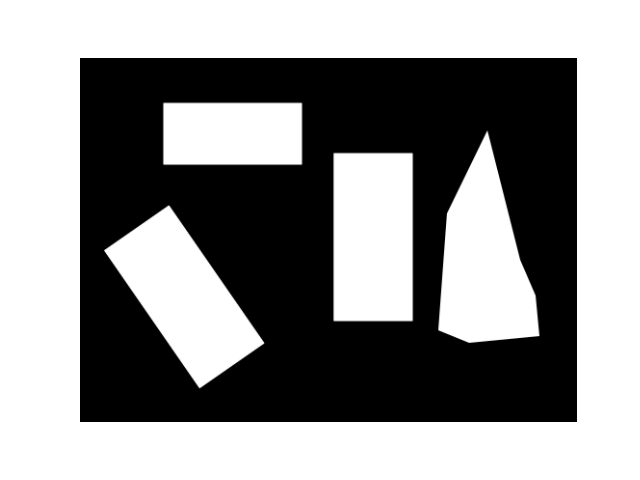

In [25]:
plotimg(timg)

In [26]:
_, timg2 = cv2.threshold(timg, 10, 255, cv2.THRESH_BINARY)

<IPython.core.display.Javascript object>


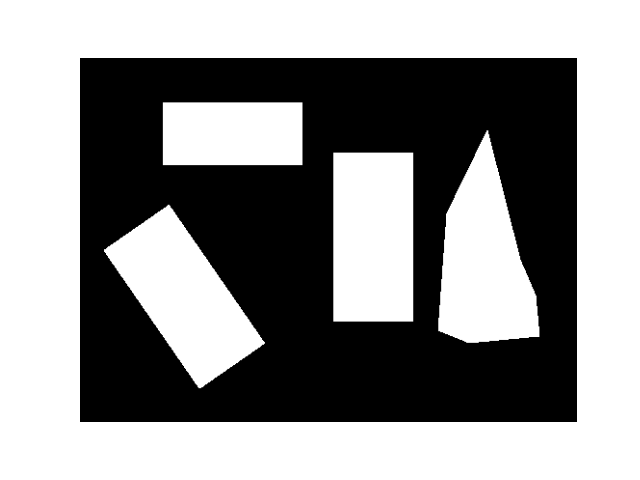

In [27]:
plotimg(timg2)

In [28]:
skeltest = getSkelline(timg2)

<IPython.core.display.Javascript object>


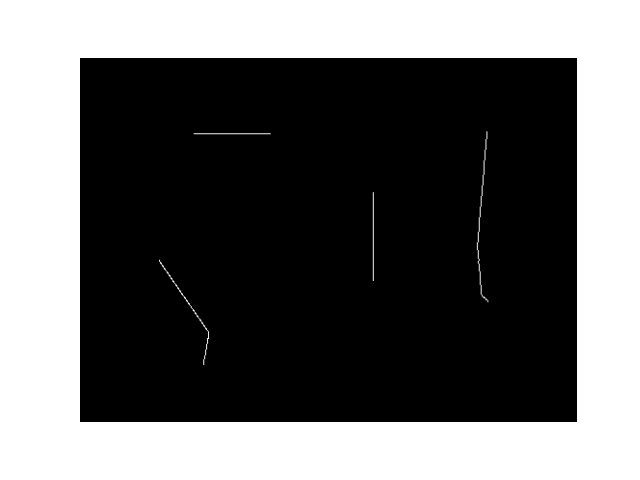

In [29]:
plotimg(skeltest)


In [30]:
print(33 % 6)

3
